# NLP, Naive Bayes, Cambridge Analytica, and Facebook

![Cambridge Analytica logo on a phone in the foreground, with Facebook's logo in the background](https://imgur.com/mNXuoXU.jpg)
*Getty Images*

In [198]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

pd.options.display.max_rows = 200 #increasing maximum viewable rows and columns
pd.options.display.max_columns = 200

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The data science process:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

## Step 1: Define the problem.

Many organizations have a substantial interest in classifying users of their product into groups. 

With that in mind, let's place ourselves in the shoes of a Facebook engineer.

Many of us are familiar with the whole Cambridge Analytica and how it tarnished Facebook's reputation since they were able to use Facebook's data in a bid to sway electoral outcomes.

Cambridge Analytica, an organization staffed with lots of Ph.D. researchers, used the Big5 personality groupings (also called OCEAN) to group people into one of 32 different groups.
- The five qualities measured by this personality assessment are:
    - **O**penness
    - **C**onscientiousness
    - **E**xtroversion
    - **A**greeableness
    - **N**euroticism
- Each person could be classified as "Yes" or "No" for each of the five qualities.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$)
- You can learn more on [Wikipedia](https://en.wikipedia.org/wiki/Big_Five_personality_traits) about the Big5 personality traits.
- There's also [a short (3-4 pages) academic paper describing part of this approach](./celli-al_wcpr13.pdf) if you're *really* interested.

Cambridge Analytica's methodology was, roughly, as follows:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big5 personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

You want to know the **real-world problem**: "Is what Cambridge Analytica attempted to do actually possible, or is it junk science?"

However, we'll solve the related **data science problem**: "Are one's Facebook statuses predictive of whether or not one is agreeable?"
> Note: If Facebook statuses aren't predictive of one being agreeable (one of the OCEAN qualities), then Cambridge Analytica's approach won't work very well!

## Step 2: Obtain the data.

Obviously, there are plenty of opportunities to discuss the ethics surrounding this particular issue... so let's do that.

In [199]:
import pandas as pd

In [200]:
data = pd.read_csv('./mypersonality_final.csv', encoding = 'ISO-8859-1')

In [201]:
data.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
2,b7b7764cfa1c523e4e93ab2a79a946c4,is sore and wants the knot of muscles at the b...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1


### Pop quiz: What's difference between anonymity and confidentiality? 

Confidentiality:
Participation in an activity such as a research study is confidential. In these cases, participants provide personal information (e.g. name, email address, phone number), and can therefore be linked back to the results. The connection between the participants and the results are known, but the terms of the confidentiality agreement limit those who will know of this connection.

Anonymity:
In contrast, when participation is anonymous it is impossible to know whether or not an individual participated and, therefore, there is no way to determine the connection between individual participants and the results. 

### 2. Pop quiz: If that the "unique identifier" in the above data, the `#AUTHID`, is a randomly generated key so that it can never be connected back to the original poster. Have we guaranteed anonymity here? Why or why not?

Yes, because the key cannot be connected back to the original poster, making it impossible to know who it was.

### Examples of what you can do as aFacebook engineer to improve how data is used and shared

1. Make it so the information can never be tracked back to a user by doing something similar to #AUTHID.
2. Make users opt-in to sharing info about themselves, instead of having to opt-out, with advertisers and any other companies looking to use their info.
3. Make it so that if users opt-out to sharing their info that they recieve the same level of service minus the targeted advertising.

## Step 3: Explore the data.

- Note: For our $X$ variable, we'll only use the `STATUS` variable. For our $Y$ variable, we'll only use the `cAGR` variable.

In [202]:
data['cAGR'].unique()

array(['n', 'y'], dtype=object)

In [203]:
data['cAGR'].value_counts(normalize=True)

y    0.531209
n    0.468791
Name: cAGR, dtype: float64

In [204]:
data['cAGR'] = data['cAGR'].map({'n': 0, 'y': 1})
data.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,0,n,y,06/19/09 03:21 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,2.65,3.0,3.15,3.25,4.4,n,y,0,n,y,07/02/09 08:41 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
2,b7b7764cfa1c523e4e93ab2a79a946c4,is sore and wants the knot of muscles at the b...,2.65,3.0,3.15,3.25,4.4,n,y,0,n,y,06/15/09 01:15 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,0,n,y,06/22/09 04:48 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,0,n,y,07/20/09 02:31 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1


In [205]:
data.isnull().sum()

#AUTHID         0
STATUS          0
sEXT            0
sNEU            0
sAGR            0
sCON            0
sOPN            0
cEXT            0
cNEU            0
cAGR            0
cCON            0
cOPN            0
DATE            0
NETWORKSIZE     0
BETWEENNESS     0
NBETWEENNESS    0
DENSITY         0
BROKERAGE       0
NBROKERAGE      0
TRANSITIVITY    1
dtype: int64

In [206]:
data = data.dropna(inplace = True)

In [207]:
# Split dataa into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Instantiate CountVectorizer.
cv = CountVectorizer()

# Fit CountVectorizer to training data.
cv.fit(X_train)

# Transform training and testing data based on the fit CountVectorizer.
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [208]:
# Create a DataFrame with our words.
words = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [209]:
# Let's look at the most frequently used words.
words.sum().sort_values(ascending=False).head(20)

propname    981
day         392
like        382
get         366
one         349
go          327
time        325
going       318
today       310
back        295
new         291
work        280
good        278
got         233
night       224
know        211
love        208
tomorrow    206
people      199
see         198
dtype: int64

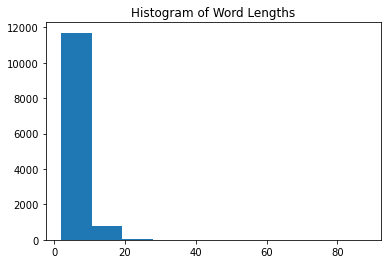

In [210]:
# Plot the lengths of the words.
lengths_of_words = [len(each) for each in words.columns]
plt.hist(lengths_of_words)
plt.title('Histogram of Word Lengths');

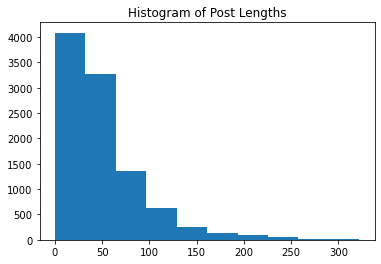

In [211]:
# Plot the lengths of the posts.
lengths_of_posts = [len(each) for each in X]
plt.hist(lengths_of_posts)
plt.title('Histogram of Post Lengths');

### CountVectorizer and TFIDFVectorizer

In CountVectorizer, we only count the number of times a word appears in documents, which results in biasing in favour of most frequent words. This approach ends up in ignoring rare words, which could help process our data more efficiently.

In TfidfVectorizer we consider overall document weightage of a word. It penalizes words that are used with greater frequencey between documents. A TF-IDF score tells us which words are most differentiating between documents. Words that occur often in one document but don't occur in many documents contain a great deal of predictive power. Consequently, it gives greater weigh to words that are rarer relative to all documents.

### Stopwords

Stopwords are commonly used words that provide little to no informational value. By removing them, it's easier to focus on the words that truly differentiate one document from the next.

If we think these words don't help explain our  𝑌  variable, we might remove them. 

(For example, in sentiment analysis, we might not think that people who use "the" more or less frequently are happier or angrier.)

If we think these words do help explain our  𝑌  variable, we might keep them. 

(For example, if we're classifying the era of a poem, the frequency of the word "the" may be helpful information!)

## Step 4: Model the data.

We are going to fit two types of models: a logistic regression and [a Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html).

**Reminder:** We will only use the feature `STATUS` to model `cAGR`.

### We'll attempt to fit our models on sixteen sets of features:

1. CountVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
2. CountVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
3. CountVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
4. CountVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
5. CountVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
6. CountVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
7. CountVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
8. CountVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.
9. TFIDFVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
10. TFIDFVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
11. TFIDFVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
12. TFIDFVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
13. TFIDFVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
14. TFIDFVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
15. TFIDFVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
16. TFIDFVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.

### Rather than manually instantiating 16 different vectorizers, we'll use pipelines to make things easier on ourselves!

In [212]:
# Instantiate pipeline.
pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

# Define grid of parameters to GridSearch over.
params_grid = {
    'cv__max_features': [100, 500],
    'cv__stop_words': ['english', None],
    'cv__ngram_range': [(1,1), (1,2)]
}

# GridSearch over pipeline with given grid of parameters.
gs_cv = GridSearchCV(pipe_cv, params_grid, cv=5)

# Fit model.
gs_cv.fit(X_train, y_train)

print(f'GridSearch score with CountVectorized features on training set is {round(gs_cv.score(X_train, y_train), 4)}.')
print()
print(f'GridSearch score with CountVectorized features on testing set is {round(gs_cv.score(X_test, y_test), 4)}.')

GridSearch score with CountVectorized features on training set is 0.6195.

GridSearch score with CountVectorized features on testing set is 0.5434.


In [213]:
# Instantiate pipeline.
pipe_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

# Define grid of parameters to GridSearch over.
params_grid = {
    'tf__max_features': [100, 500],
    'tf__stop_words': ['english', None],
    'tf__ngram_range': [(1,1), (1,2)]
}

# GridSearch over pipeline with given grid of parameters.
gs_tf = GridSearchCV(pipe_tf, params_grid, cv=5)

# Fit model.
gs_tf.fit(X_train, y_train)

print(f'GridSearch score with TFIDFVectorized features on training set is {round(gs_tf.score(X_train, y_train),4)}.')
print()
print(f'GridSearch score with TFIDFVectorized features on testing set is {round(gs_tf.score(X_test, y_test),4)}.')

GridSearch score with TFIDFVectorized features on training set is 0.6189.

GridSearch score with TFIDFVectorized features on testing set is 0.5426.


### Advantages to fitting a logistic regression model

- Logistic regression models are fast to fit.
- Logistic regression models allow for us to interpret coefficients and the association between individual independent variables and the dependent variable. (Though it takes some computation to interpret them.)
- Logistic regression models are more widely used and thus better understood than other techniques.
- Logistic regression models often perform on par with or better than more "complex"/unfamiliar machine learning methods.

### Let's fit a logistic regression model and compare it to the baseline

In [214]:
# baseline performance.
y_train.value_counts(normalize=True)

1    0.531128
0    0.468872
Name: cAGR, dtype: float64

In [215]:
# Grab best estimator from gs_cv.
lr_model = gs_cv.estimator

In [216]:
# Fit model.
lr_model.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [219]:
print(f'Training accuracy score for our logistic regression model is: {round(lr_model.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our logistic regression model is: {round(lr_model.score(X_test, y_test),4)}.')

Training accuracy score for our logistic regression model is: 0.9107.
Testing accuracy score for our logistic regression model is: 0.5845.


### Naive Bayes 

A classification technique that relies on probability to classify observations:
- It's based on a probability rule called **Bayes' Theorem**... thus, "**Bayes**."
- It makes an assumption that isn't often met, so it's "**naive**."

Despite being a model that relies on a naive assumption, it often performs pretty well! 

(This is kind of like linear regression... we aren't always guaranteed homoscedastic errors in linear regression, but the model might still do a good job regardless.)

- [Read more here if you're interested.](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf)

#### Bayes' Theorem
If you've seen Bayes' Theorem, it relates the probability of $P(A|B)$ to $P(B|A)$. 

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

- Let $A$ be that someone is "agreeable," like the OCEAN category.
- Let $B$ represent the words used in their Facebook post.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)} \\
\Rightarrow P(\text{person is agreeable}|\text{words in Facebook post}) &=& \frac{P(\text{words in Facebook post}|\text{person is agreeable})P(\text{person is agreeable})}{P(\text{words in Facebook post})}
\end{eqnarray*}
$$

We want to calculate the probability that someone is agreeable **given** the words that they used in their Facebook post! 

(Rather than calculating this probability by hand, this is done under the hood and we can just see the results by checking `.predict_proba()`.) However, this is exactly what our model is doing. We can (a.k.a. the model can) calculate the pieces on the right-hand side of the equation to give us a probability estimate of how likely someone is to be agreeable given their Facebook post.

#### Naive Assumption

If our goal is to estimate $P(\text{person is agreeable}|\text{words in Facebook post})$, that can be quite tricky.

To simplify matters, we make an assumption: **we assume that all of our features are independent of one another.**

In some contexts, this assumption might be realistic!

### Why would this assumption not be realistic with NLP data?

Because the meaning of a sentence is dependent on the words within it. 

Text has little to no meaning without taking into the consideration the words that come before and after it.

Despite this assumption not being realistic with NLP data, we still use Naive Bayes pretty frequently.
- It's a very fast modeling algorithm. (which is great especially when we have lots of features and/or lots of data!)
- It is often an excellent classifier, outperforming more complicated models.

There are three common types of Naive Bayes models: Bernoulli Naive Bayes, Multinomial Naive Bayes, and Gaussian Naive Bayes.
- How do we pick which of the three models to use? It depends on our $X$ variable.
    - Bernoulli Naive Bayes is appropriate when our features are all 0/1 variables.
        - [Bernoulli NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
    - Multinomial Naive Bayes is appropriate when our features are variables that take on only positive integer counts.
        - [Multinomial NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)
    - Gaussian Naive Bayes is appropriate when our features are Normally distributed variables. (Realistically, though, we kind of use Gaussian whenever neither Bernoulli nor Multinomial works.)
        - [Gaussian NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

### If we're going CountVectorize our features, we'd use  Multinomial Naive Bayes...

Because the the variables are integer counts.

In [220]:
# Instantiate Multinomial Naive Bayes model.
mnb = MultinomialNB()

# Fit model.
mnb.fit(X_train_cv, y_train)

# Evaluate predictions.
print(f'Training accuracy score for our Multinomial Naive Bayes model is: {round(mnb.score(X_train_cv, y_train),4)}.')
print()
print(f'Testing accuracy score for our Multinomial Naive Bayes model is: {round(mnb.score(X_test_cv, y_test),4)}.')

Training accuracy score for our Multinomial Naive Bayes model is: 0.8674.

Testing accuracy score for our Multinomial Naive Bayes model is: 0.6123.


### 14. If we TFIDFVectorize oour features, we'd use  Gaussian Naive Bayes...

Because X is a float and also not a count.

In [221]:
# Instantiate TFIDFVectorizer.
tf = TfidfVectorizer()

# Fit vectorizer.
tf.fit(X_train, y_train)

# Transform training and testing sets.
X_train_tf = tf.transform(X_train).todense()
X_test_tf = tf.transform(X_test).todense()

# Instantiate Gaussian Naive Bayes model.
gnb = GaussianNB()

# Fit model.
gnb.fit(X_train_tf, y_train)

# Evaluate predictions,
print(f'Training accuracy score for our Gaussian Naive Bayes model is: {round(gnb.score(X_train_tf, y_train),4)}.')
print()
print(f'Testing accuracy score for our Gaussian Naive Bayes model is: {round(gnb.score(X_test_tf, y_test),4)}.')

Training accuracy score for our Gaussian Naive Bayes model is: 0.8653.

Testing accuracy score for our Gaussian Naive Bayes model is: 0.5409.


### 15. Which model the performanced the best?

In [222]:
print(f'The accuracy of a baseline model would be about {round(y_train.value_counts(normalize=True)[1],4)}.')
print()
print(f'Training accuracy score for our logistic regression model is: {round(lr_model.score(X_train, y_train),4)}.')
print()
print(f'Testing accuracy score for our logistic regression model is: {round(lr_model.score(X_test, y_test),4)}.')
print()
print(f'Training accuracy score for our Multinomial Naive Bayes model is: {round(mnb.score(X_train_cv, y_train),4)}.')
print()
print(f'Testing accuracy score for our Multinomial Naive Bayes model is: {round(mnb.score(X_test_cv, y_test),4)}.')
print()
print(f'Training accuracy score for our Gaussian Naive Bayes model is: {round(gnb.score(X_train_tf, y_train),4)}.')
print()
print(f'Testing accuracy score for our Gaussian Naive Bayes model is: {round(gnb.score(X_test_tf, y_test),4)}.')

The accuracy of a baseline model would be about 0.5311.

Training accuracy score for our logistic regression model is: 0.9107.

Testing accuracy score for our logistic regression model is: 0.5845.

Training accuracy score for our Multinomial Naive Bayes model is: 0.8674.

Testing accuracy score for our Multinomial Naive Bayes model is: 0.6123.

Training accuracy score for our Gaussian Naive Bayes model is: 0.8653.

Testing accuracy score for our Gaussian Naive Bayes model is: 0.5409.


It looks like our MNB model perfromed the best with 61%, which is 8 points above baseline or a 14.6% increase.

### Circling back to Cambridge Analytica, how effective was their approach at using Facebook data to model agreeableness?

Not very!